In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import scipy

In [66]:
os.getcwd()

'c:\\Users\\Kanishka\\OneDrive\\Desktop\\AI_DermalScan'

In [3]:
dataset = './Dataset'
outputs_path = './Outputs'
def class_distribution(dataset):
    class_num = 1
    labels = []
    counts = []
    for classes in os.listdir(dataset):
        class_path = os.path.join(dataset, classes)
        labels.append(classes)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            counts.append(num_images)
            print(f'Class {class_num}')
            print(f'Class: {classes}')
            print(f'Number of images: {num_images}')
            print('-----------------------')
            class_num += 1
    return labels, counts
labels, counts = class_distribution(dataset)
        

Class 1
Class: clear skin
Number of images: 300
-----------------------
Class 2
Class: dark spots
Number of images: 300
-----------------------
Class 3
Class: puffy eyes
Number of images: 300
-----------------------
Class 4
Class: wrinkles
Number of images: 300
-----------------------


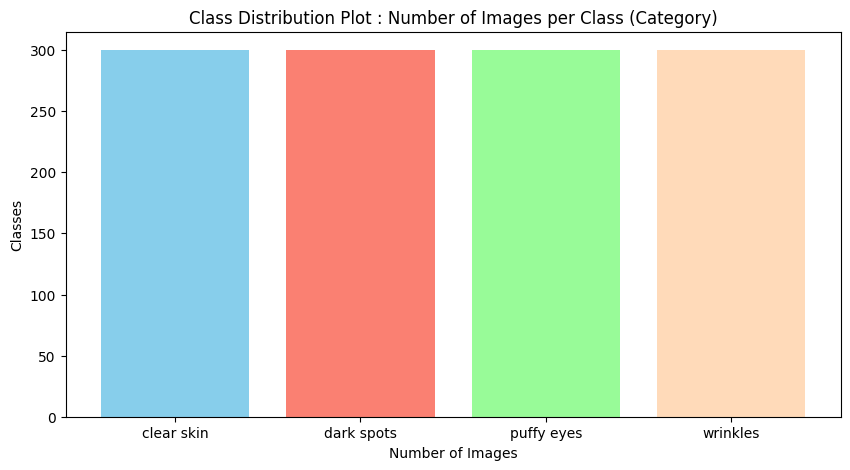

In [4]:
def plot_class_distribution(labels, counts):
    plt.figure(figsize=(10,5))
    plt.bar(labels, counts,color=('skyblue','salmon','palegreen','peachpuff'))
    plt.title('Class Distribution Plot : Number of Images per Class (Category)')
    plt.xlabel('Number of Images')
    plt.ylabel('Classes')
    plt.savefig('Class_Distribution_Plot.png')
    plt.show()
plot_class_distribution(labels, counts)

In [5]:
#This function plots the augmentation scattering per batch

def plot_augmentation_scattering(generator, title="Augmentation Scattering Per Batch"):

    images, labels = next(generator)

    class_indices = np.argmax(labels, axis=1) #to get the class indices from one-hot encoded labels

    # count how many images per class appear in the batch
    unique_classes, counts = np.unique(class_indices, return_counts=True)

    # class names
    class_labels = list(generator.class_indices.keys())

    # Plot
    plt.figure(figsize=(8, 5))
    plt.bar(class_labels, counts)
    plt.xlabel("Classes")
    plt.ylabel("Images in this batch")
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.show()

    return unique_classes, counts

In [6]:
#In this cell a generator object is created for training and validation data augmentation. The rules for augmentation are defined within the ImageDataGenerator function.

train_datagen = ImageDataGenerator(
    rescale=1./255,          
    rotation_range=20,       
    width_shift_range=0.15,   
    height_shift_range=0.15,  
    zoom_range=0.2,          
    horizontal_flip=True,    
    fill_mode='nearest',     
    validation_split=0.2,
    brightness_range=[0.8,1.2]     
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [7]:
#In this cell, the augmentation generator is applied to actual image data from the dataset directory. The images are resized to 224x224 pixels, and the batch size is set to 32. Training and validation subsets are created based on the defined split.(80-20)

img_size = (224, 224)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    dataset,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  #One-hot encoding
    shuffle=True,
    subset='training'
)

valid_generator = valid_datagen.flow_from_directory(
    dataset,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)



Found 960 images belonging to 4 classes.
Found 240 images belonging to 4 classes.


One-hot encoded labels:
 [[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


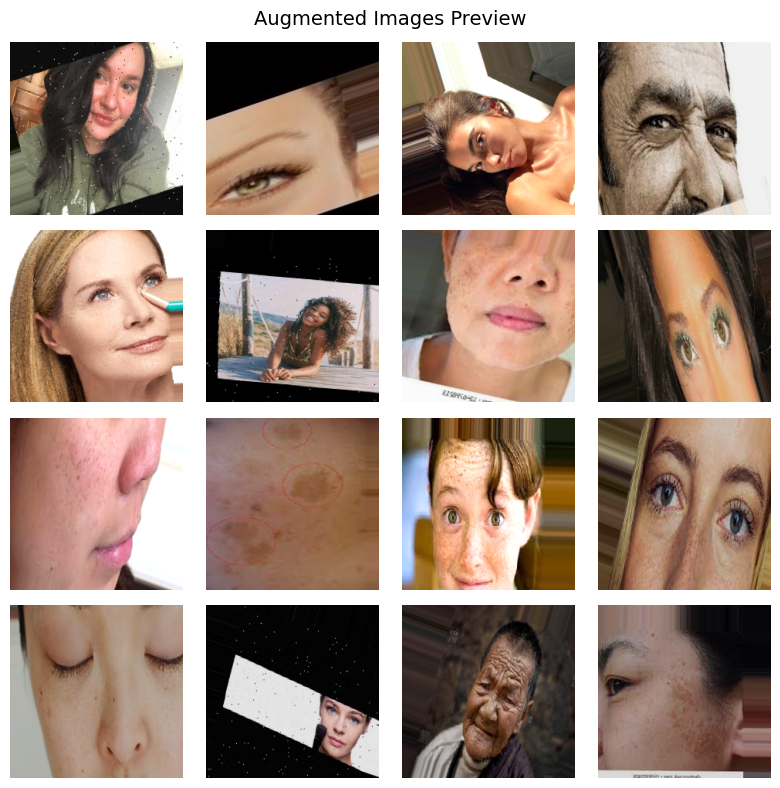

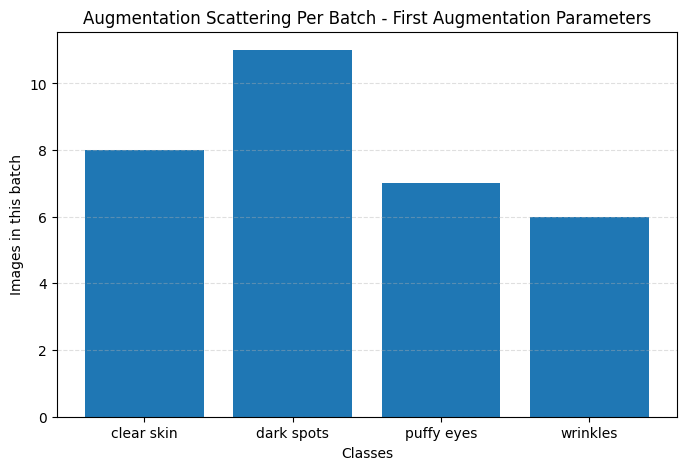

(array([0, 1, 2, 3], dtype=int64), array([ 8, 11,  7,  6], dtype=int64))

In [8]:
#See augmented images using the First augmentation parameters
# Take one batch from train generator
images, labels = next(train_generator)
print("One-hot encoded labels:\n", labels)


plt.figure(figsize=(8, 8))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

plt.suptitle("Augmented Images Preview", fontsize=14)
plt.tight_layout()

# Save the figure
count = len(os.listdir('Outputs'))
filename = f'Outputs/Augmented_Images_{count+1}.png'
plt.savefig(filename)

plt.show()

plot_augmentation_scattering(train_generator, title="Augmentation Scattering Per Batch - First Augmentation Parameters")

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(base_model, num_classes, lr=1e-4, dropout_rate=0.5):

    # Freeze base model
    base_model.trainable = False

    # Custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [10]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping

# Load pretrained MobileNetV2
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Build model
model = build_model(
    base_model=base_model,
    num_classes=train_generator.num_classes,
    lr=1e-4,
    dropout_rate=0.5
)

# Callbacks for Phase 1
callbacks_phase1 = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=6,
        restore_best_weights=True
    )
]

# Train (Feature Extraction)
history_phase1 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    callbacks=callbacks_phase1
)




Epoch 1/15


30/30 [==============================] - 20s 552ms/step - loss: 2.0120 - accuracy: 0.2333 - val_loss: 1.5010 - val_accuracy: 0.2583
Epoch 2/15
30/30 [==============================] - 14s 473ms/step - loss: 1.8847 - accuracy: 0.2729 - val_loss: 1.3273 - val_accuracy: 0.3625
Epoch 3/15
30/30 [==============================] - 14s 464ms/step - loss: 1.6281 - accuracy: 0.3333 - val_loss: 1.2028 - val_accuracy: 0.4583
Epoch 4/15
30/30 [==============================] - 15s 492ms/step - loss: 1.5578 - accuracy: 0.3635 - val_loss: 1.0994 - val_accuracy: 0.5333
Epoch 5/15
30/30 [==============================] - 16s 520ms/step - loss: 1.4746 - accuracy: 0.3969 - val_loss: 1.0166 - val_accuracy: 0.5792
Epoch 6/15
30/30 [==============================] - 14s 472ms/step - loss: 1.3654 - accuracy: 0.4271 - val_loss: 0.9399 - val_accuracy: 0.6167
Epoch 7/15
30/30 [==============================] - 14s 471ms/step - loss: 1.2693 - accuracy: 0.4927 - val_loss: 0.8769 - val_accuracy: 0.

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Unfreeze top layers for fine-tuning
base_model.trainable = True

for layer in base_model.layers[:-80]:
    layer.trainable = False


model.compile(
    optimizer=Adam(learning_rate=5e-6), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_finetune = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=2,
        min_lr=1e-6
    )
]

history_finetune = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=callbacks_finetune
)

model.save("MobileNetV2_finetuned.h5")



Epoch 1/10
30/30 [==============================] - 24s 577ms/step - loss: 1.2427 - accuracy: 0.4771 - val_loss: 0.5899 - val_accuracy: 0.7917 - lr: 5.0000e-06
Epoch 2/10
30/30 [==============================] - 16s 545ms/step - loss: 1.1625 - accuracy: 0.5083 - val_loss: 0.5625 - val_accuracy: 0.8000 - lr: 5.0000e-06
Epoch 3/10
30/30 [==============================] - 16s 540ms/step - loss: 1.0861 - accuracy: 0.5542 - val_loss: 0.5416 - val_accuracy: 0.8167 - lr: 5.0000e-06
Epoch 4/10
30/30 [==============================] - 16s 532ms/step - loss: 0.9872 - accuracy: 0.5896 - val_loss: 0.5243 - val_accuracy: 0.8208 - lr: 5.0000e-06
Epoch 5/10
30/30 [==============================] - 18s 585ms/step - loss: 0.9153 - accuracy: 0.6323 - val_loss: 0.5086 - val_accuracy: 0.8250 - lr: 5.0000e-06
Epoch 6/10
30/30 [==============================] - 38s 1s/step - loss: 0.8658 - accuracy: 0.6271 - val_loss: 0.4932 - val_accuracy: 0.8375 - lr: 5.0000e-06
Epoch 7/10
30/30 [=========================

c:\Users\Kanishka\OneDrive\Desktop\AI_DermalScan\tf_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
best_val_acc = max(history_finetune.history['val_accuracy'])
best_epoch = history_finetune.history['val_accuracy'].index(best_val_acc) + 1
best_train_acc = max(history_finetune.history['accuracy'])

print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Best Epoch: {best_epoch}")
print(f"Best Training Accuracy: {best_train_acc:.4f}")




Best Validation Accuracy: 0.8458
Best Epoch: 10
Best Training Accuracy: 0.7198


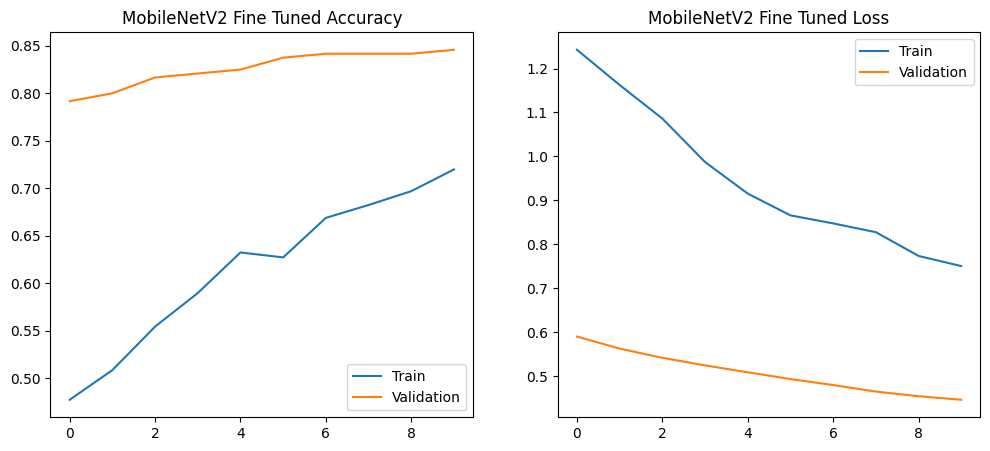

MobileNetV2: 0.8458333611488342
MobileNetV2: 0.7197916507720947


In [15]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{model_name} Loss')
    plt.legend()

    plt.show()

plot_history(history_finetune, "MobileNetV2 Fine Tuned")

print("MobileNetV2:", max(history_finetune.history['val_accuracy']))
print('MobileNetV2:', max(history_finetune.history['accuracy']))


